## Problem Statement: Predict whether given Hospital Insuarance Claim is Graud or genuine.

* Author: Shrikant U.

****
****

# Step 1: Importing Libraries..

In [1]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import StratifiedKFold 
from collections import Counter

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)

# Step 2: Dataset loading and Preprocessing..

In [2]:
dataset = pd.read_csv('dataset.csv')

In [3]:
dataset.head(2)

,Area_Service,Hospital County,Hospital Id,Age,Gender,Cultural_group,ethnicity,Days_spend_hsptl,Admission_type,"Home or self care,",ccs_diagnosis_code,ccs_procedure_code,apr_drg_description,Code_illness,Mortality risk,Surg_Description,Weight_baby,Abortion,Emergency dept_yes/No,Tot_charg,Tot_cost,ratio_of_total_costs_to_total_charges,Result,Payment_Typology
0,Western NY,Allegany,37.0,30 to 49,F,White,Not Span/Hispanic,4,Elective,Home or Self Care,122,0,Other pneumonia,1,1.0,Medical,0,N,Y,5511.95,5582.49,1.012798,1,1
1,Western NY,Allegany,37.0,70 or Older,F,White,Not Span/Hispanic,4,Urgent,Short-term Hospital,197,0,Cellulitis & other skin infections,3,2.0,Medical,0,N,Y,4783.20,5162.82,1.079365,1,1


In [4]:
dataset.columns

Index(['Area_Service', 'Hospital County', 'Hospital Id', 'Age', 'Gender',
       'Cultural_group', 'ethnicity', 'Days_spend_hsptl', 'Admission_type',
       'Home or self care,', 'ccs_diagnosis_code', 'ccs_procedure_code',
       'apr_drg_description', 'Code_illness', 'Mortality risk',
       'Surg_Description', 'Weight_baby', 'Abortion', 'Emergency dept_yes/No',
       'Tot_charg', 'Tot_cost', 'ratio_of_total_costs_to_total_charges',
       'Result', 'Payment_Typology'],
      dtype='object')

In [5]:
# removing spaces in dataset column names..

dataset.columns = dataset.columns.to_series().apply(lambda x: x.replace(' ', '_')).to_list()
dataset.columns = dataset.columns.to_series().apply(lambda x: x.replace('/', '_')).to_list()
dataset.columns.values

array(['Area_Service', 'Hospital_County', 'Hospital_Id', 'Age', 'Gender',
       'Cultural_group', 'ethnicity', 'Days_spend_hsptl',
       'Admission_type', 'Home_or_self_care,', 'ccs_diagnosis_code',
       'ccs_procedure_code', 'apr_drg_description', 'Code_illness',
       'Mortality_risk', 'Surg_Description', 'Weight_baby', 'Abortion',
       'Emergency_dept_yes_No', 'Tot_charg', 'Tot_cost',
       'ratio_of_total_costs_to_total_charges', 'Result',
       'Payment_Typology'], dtype=object)

In [6]:
dataset.rename(columns={'Home_or_self_care,': 'Home_or_self_care'}, inplace=True)

In [7]:
data= pd.read_csv('dataset.csv')
data_sample_view = data.head(2)

In [8]:
# for deployment part...sample dataframe view..
dump(data_sample_view, 'data_sample_view.joblib')

['data_sample_view.joblib']

In [9]:
dataset.shape

(1048575, 24)

In [10]:
dataset.drop_duplicates(inplace=True)

In [11]:
dataset.dropna(inplace=True)

In [12]:
dataset.shape

(1041265, 24)

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041265 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   Area_Service                           1041265 non-null  object 
 1   Hospital_County                        1041265 non-null  object 
 2   Hospital_Id                            1041265 non-null  float64
 3   Age                                    1041265 non-null  object 
 4   Gender                                 1041265 non-null  object 
 5   Cultural_group                         1041265 non-null  object 
 6   ethnicity                              1041265 non-null  object 
 7   Days_spend_hsptl                       1041265 non-null  object 
 8   Admission_type                         1041265 non-null  object 
 9   Home_or_self_care                      1041265 non-null  object 
 10  ccs_diagnosis_code                     104

In [14]:
dataset.select_dtypes(include=['object']).head(2)

,Area_Service,Hospital_County,Age,Gender,Cultural_group,ethnicity,Days_spend_hsptl,Admission_type,Home_or_self_care,apr_drg_description,Surg_Description,Abortion,Emergency_dept_yes_No
0,Western NY,Allegany,30 to 49,F,White,Not Span/Hispanic,4,Elective,Home or Self Care,Other pneumonia,Medical,N,Y
1,Western NY,Allegany,70 or Older,F,White,Not Span/Hispanic,4,Urgent,Short-term Hospital,Cellulitis & other skin infections,Medical,N,Y


* It shows days spend hspt column as obejct type. So checking unique values & dealing with it.

In [15]:
#### trying to convert string formatted data to integer / find out which value is not getting converted to integer datatype

for i in dataset.Days_spend_hsptl.unique():
    try:
        int(i)
    except ValueError:
        print(i)

120 +


So we have '120 +' entry in Days_spend_hsptl column. that is days spend hospital is more than 120..

So we can replace it by integer 120 & Convert this column to integer dataype

In [16]:
# replacing value

dataset.replace({'Days_spend_hsptl': '120 +'}, 120, inplace=True)

In [17]:
# converting to intger datatype column..

dataset.Days_spend_hsptl = dataset.Days_spend_hsptl.astype('int')

In [18]:
dataset.select_dtypes(exclude='object').head(2)

,Hospital_Id,Days_spend_hsptl,ccs_diagnosis_code,ccs_procedure_code,Code_illness,Mortality_risk,Weight_baby,Tot_charg,Tot_cost,ratio_of_total_costs_to_total_charges,Result,Payment_Typology
0,37.0,4,122,0,1,1.0,0,5511.95,5582.49,1.012798,1,1
1,37.0,4,197,0,3,2.0,0,4783.20,5162.82,1.079365,1,1


In [19]:
dataset.Hospital_Id = dataset.Hospital_Id.astype('int')
dataset.Mortality_risk = dataset.Mortality_risk.astype('int')

##### Dropping non-importanat columns...source: EDA-Discussion-part-II

In [20]:
dataset.drop(['Hospital_Id', 'apr_drg_description', 'Abortion', 'Weight_baby'], axis=1, inplace=True)

In [21]:
dataset.head(2)

,Area_Service,Hospital_County,Age,Gender,Cultural_group,ethnicity,Days_spend_hsptl,Admission_type,Home_or_self_care,ccs_diagnosis_code,ccs_procedure_code,Code_illness,Mortality_risk,Surg_Description,Emergency_dept_yes_No,Tot_charg,Tot_cost,ratio_of_total_costs_to_total_charges,Result,Payment_Typology
0,Western NY,Allegany,30 to 49,F,White,Not Span/Hispanic,4,Elective,Home or Self Care,122,0,1,1,Medical,Y,5511.95,5582.49,1.012798,1,1
1,Western NY,Allegany,70 or Older,F,White,Not Span/Hispanic,4,Urgent,Short-term Hospital,197,0,3,2,Medical,Y,4783.20,5162.82,1.079365,1,1


### encoding...

#### Making it for deployment ppoint of view..

In [22]:
dataset.select_dtypes(include=['object']).head(2)

,Area_Service,Hospital_County,Age,Gender,Cultural_group,ethnicity,Admission_type,Home_or_self_care,Surg_Description,Emergency_dept_yes_No
0,Western NY,Allegany,30 to 49,F,White,Not Span/Hispanic,Elective,Home or Self Care,Medical,Y
1,Western NY,Allegany,70 or Older,F,White,Not Span/Hispanic,Urgent,Short-term Hospital,Medical,Y


In [23]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
label = LabelEncoder()
label_binizer =LabelBinarizer()

In [24]:
label_area = label.fit(dataset.Area_Service)
label_Hospital_County = label.fit(dataset.Hospital_County)
label_Age = label.fit(dataset.Age)
label_Cultural_group = label.fit(dataset.Cultural_group)
label_ethnicity= label.fit(dataset.ethnicity)
label_Admission_type = label.fit(dataset.Admission_type)
label_Home_or_self_care = label.fit(dataset.Home_or_self_care)

In [25]:
one_hot_Gender = label_binizer.fit(dataset.Gender)
one_hot_Surg_Description = label_binizer.fit(dataset.Surg_Description)
one_hot_Emergency_dept_yes_No = label_binizer.fit(dataset.Emergency_dept_yes_No)

In [26]:
label_encoder_list = [label_area, label_Hospital_County,
                label_Age, label_Cultural_group,
                label_ethnicity, label_Admission_type,
                label_Home_or_self_care]

one_hot_coder_list = [one_hot_Gender, one_hot_Surg_Description, one_hot_Emergency_dept_yes_No]

#### pickling encoding object & columns for deployment point of view...

In [165]:
from joblib import dump, load

In [166]:
dump(label_encoder_list, 'label_encoder_list.joblib')

['label_encoder_list.joblib']

In [167]:
dump(one_hot_coder_list, 'one_hot_coder_list.joblib')

['one_hot_coder_list.joblib']

In [168]:
label_to_column = ['Area_Service', 'Hospital_County',
                  'Age', 'Cultural_group', 'ethnicity',
                  'Admission_type', 'Home_or_self_care']

one_hot_column = ['Gender', 'Surg_Description', 'Emergency_dept_yes_No']

In [169]:
dump(label_to_column, 'label_to_column.joblib')

['label_to_column.joblib']

In [170]:
dump(one_hot_column, 'one_hot_column.joblib')

['one_hot_column.joblib']

In [33]:
# applyibng label encoding on columns..also this below cells can be used in deployment as well

In [29]:
j = 0
for i in label_to_column:
    dataset[i] = label_encoder_list[j].fit_transform(dataset[i])
    j =+1

In [ ]:
# applyibng one hot encoding on columns..also this below cells can be used in deployment as well

In [30]:
k = 0
for i in one_hot_column:
    dataset[i] = one_hot_coder_list[k].fit_transform(dataset[i])
    k =+1

In [35]:
dataset.head()

,Area_Service,Hospital_County,Age,Gender,Cultural_group,ethnicity,Days_spend_hsptl,Admission_type,Home_or_self_care,ccs_diagnosis_code,ccs_procedure_code,Code_illness,Mortality_risk,Surg_Description,Emergency_dept_yes_No,Tot_charg,Tot_cost,ratio_of_total_costs_to_total_charges,Result,Payment_Typology
0,6,1,2,1,3,0,4,0,7,122,0,1,1,0,1,5511.95,5582.49,1.012798,1,1
1,6,1,4,1,3,0,4,5,17,197,0,3,2,0,1,4783.20,5162.82,1.079365,1,1
2,6,1,2,1,3,0,3,5,7,122,0,1,1,0,1,3829.15,4056.52,1.059379,1,1
3,6,1,0,1,3,0,1,5,7,122,0,1,1,0,1,1108.20,1644.75,1.484167,0,1
4,6,1,4,1,3,0,3,0,7,122,0,2,3,0,1,3418.18,3370.87,0.986161,1,1


### Data Imbalance...

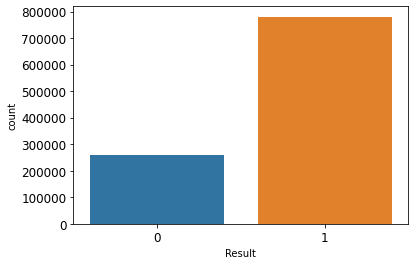

In [170]:
sns.countplot(dataset.Result)
plt.show()

# Step 3: Model By different strategy...

#### Performing on sample datasets...

In [171]:
# taking 5% sample data from whole dataset

sample_data = dataset.sample(frac=0.02)

In [40]:
# checking for result column unique values counts..

sample_data.Result.value_counts()

1    15518
0     5307
Name: Result, dtype: int64

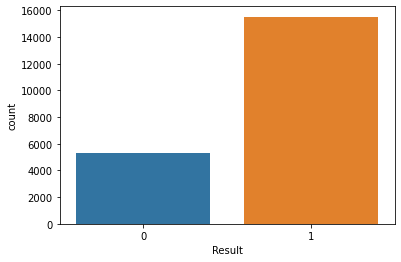

In [41]:
sns.countplot(sample_data.Result)
plt.show()

## 3.1 Upsampling before splitting the data into train & test
****

In [42]:
# seperating '0', & '1' label 

sample_minority = sample_data.loc[sample_data['Result']==0]
sample_majority = sample_data.loc[sample_data['Result']==1]

In [43]:
# doing upsampling of minority classes... taking 100 to 80% ratio

# sample_majority.shape[0]*0.80

from sklearn.utils import resample
sample_data_minority_upsampled = resample(sample_minority , replace=True, n_samples=12000, random_state=42)

In [44]:
# combining upsampled data to majority class data...

sample_data_upsampled = pd.concat([sample_majority, sample_data_minority_upsampled ], ignore_index=True)

In [45]:
# seperating indepedent & depedent variabales..

x = sample_data_upsampled.drop(['Result'],axis=1).values
y = sample_data_upsampled.Result.values

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=42)

In [47]:
# finding best ccp_alph tree prunning parameter. So that it will avoid overfit issue

def find_alpha(x_train, x_test, y_train, y_test):
    
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestClassifier
    
    
    ccp_alphas = np.arange(0.000, 0.040, 0.002)
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = RandomForestClassifier(n_estimators=15, random_state=42, ccp_alpha=ccp_alpha)
        clf.fit(x_train, y_train)
        clfs.append(clf)

    train_scores = [clf.score(x_train, y_train) for clf in clfs]
    test_scores = [clf.score(x_test, y_test) for clf in clfs]

    fig, ax = plt.subplots(figsize=(15,6))
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
    ax.set_xticks(np.arange(0.000,0.040, 0.002))
    ax.set_yticks(np.arange(0.70,1.01, 0.1))
    ax.legend()
    plt.grid(True)
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    plt.show()


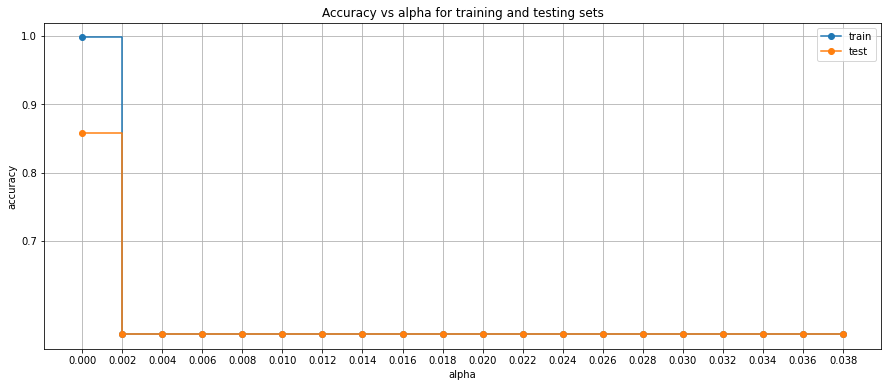

In [48]:
find_alpha(x_train, x_test, y_train, y_test)

* ccp_alph parameter should be zero for this case.

### Building Model with n_estimators=100

In [49]:
from sklearn.ensemble import RandomForestClassifier
sample_RF_upsampled = RandomForestClassifier(n_estimators=100, random_state=42)

In [51]:
clf_sample = sample_RF_upsampled.fit(x_train, y_train)

In [53]:
y_pred_train = clf_sample.predict(x_train)
y_pred = clf_sample.predict(x_test)

In [54]:
print(classification_report(y_train, y_pred_train ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9600
           1       1.00      1.00      1.00     12414

    accuracy                           1.00     22014
   macro avg       1.00      1.00      1.00     22014
weighted avg       1.00      1.00      1.00     22014



In [55]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2400
           1       0.88      0.93      0.91      3104

    accuracy                           0.89      5504
   macro avg       0.89      0.89      0.89      5504
weighted avg       0.89      0.89      0.89      5504



In [56]:
cross_val_score(clf_sample, x, y)

array([0.89807413, 0.90116279, 0.89607558, 0.90078139, 0.89024169])

### Building Model with n_estimators=15

In [57]:
from sklearn.ensemble import RandomForestClassifier
sample_RF15_upsampled = RandomForestClassifier(n_estimators=15, random_state=42)

In [58]:
clf_15_sample = sample_RF_upsampled.fit(x_train, y_train)

In [59]:
y_pred_train = clf_15_sample.predict(x_train)
y_pred = clf_15_sample.predict(x_test)

In [60]:
print(classification_report(y_train, y_pred_train ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9600
           1       1.00      1.00      1.00     12414

    accuracy                           1.00     22014
   macro avg       1.00      1.00      1.00     22014
weighted avg       1.00      1.00      1.00     22014



In [61]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2400
           1       0.88      0.93      0.91      3104

    accuracy                           0.89      5504
   macro avg       0.89      0.89      0.89      5504
weighted avg       0.89      0.89      0.89      5504



In [62]:
cross_val_score(clf_15_sample, x, y)

array([0.89807413, 0.90116279, 0.89607558, 0.90078139, 0.89024169])

In [91]:
y_pred_whole = clf_15_sample.predict(dataset.drop(['Result'],axis=1))

print(classification_report(dataset.Result.values, y_pred_whole))

              precision    recall  f1-score   support

           0       0.30      0.08      0.12    260904
           1       0.75      0.94      0.84    780361

    accuracy                           0.72   1041265
   macro avg       0.53      0.51      0.48   1041265
weighted avg       0.64      0.72      0.66   1041265



## 3.2 Upsampling after train_test_split...

### 3.1 Upsampling using sklearn resample

In [63]:
x = sample_data.drop(['Result'],axis=1).values
y = sample_data.Result.values

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=42)

In [65]:
from collections import Counter
Counter(y_train)

Counter({0: 4246, 1: 12414})

In [66]:
x_train_df = pd.DataFrame(x_train, columns=sample_data.drop(['Result'],axis=1).columns)
y_train_df = pd.DataFrame(y_train, columns=['Result'])

df_train = pd.concat([x_train_df, y_train_df],axis=1)

In [67]:
df_train_majority = df_train.loc[df_train['Result']==1]
df_train_minority = df_train.loc[df_train['Result']==0]

In [68]:
df_train_majority.shape

(12414, 20)

In [69]:
df_train_minority.shape

(4246, 20)

In [70]:
# checking 80% row counts w.r.t majority class
12487*0.80

9989.6

In [71]:
# doing upsampling of minority classes... taking 100 to 80% ratio

# sample_majority.shape[0]*0.80

from sklearn.utils import resample
df_train_minority_upsampled = resample(df_train_minority , replace=True, n_samples=9990, random_state=42)

In [72]:
after_split_upsampled = pd.concat([df_train_majority, df_train_minority_upsampled])

In [73]:
# splitting into x_train, y_train only..note: we have alerady splitted test sets using k fold...

x_train_upsampled = after_split_upsampled.drop(['Result'],axis=1).values
y_train_upsampled = after_split_upsampled.Result.values

In [74]:
from sklearn.ensemble import RandomForestClassifier
sample_RF15_after_split_upsampled = RandomForestClassifier(n_estimators=15, random_state=42)

In [75]:
sample_RF15_after_split_upsampled = sample_RF15_after_split_upsampled.fit(x_train_upsampled, y_train_upsampled)

In [76]:
y_pred_train = sample_RF15_after_split_upsampled.predict(x_train_upsampled)
y_pred = sample_RF15_after_split_upsampled.predict(x_test)

In [77]:
Counter(y_test)

Counter({1: 3104, 0: 1061})

In [78]:
print(classification_report(y_train_upsampled, y_pred_train ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9990
           1       1.00      1.00      1.00     12414

    accuracy                           1.00     22404
   macro avg       1.00      1.00      1.00     22404
weighted avg       1.00      1.00      1.00     22404



In [79]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       0.25      0.09      0.14      1061
           1       0.74      0.90      0.82      3104

    accuracy                           0.70      4165
   macro avg       0.50      0.50      0.48      4165
weighted avg       0.62      0.70      0.64      4165



### Conclusion:

* It is clear that, upsampling tech. is best suited for imbalanced dataset..when we upsample minority class before train_test_split

# Step 4: Model Building On whole dataset...

In [38]:
data_minority = dataset.loc[dataset['Result']==0]
data_majority = dataset.loc[dataset['Result']==1]

In [39]:
from sklearn.utils import resample
data_minority_upsampled = resample(data_minority, replace=True, n_samples=624290, random_state=42)
data_upsampled = pd.concat([data_majority, data_minority_upsampled ], ignore_index=True)

In [174]:
X = data_upsampled.drop(['Result'],axis=1).values
Y = data_upsampled.Result.values

In [175]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=30)

In [176]:
from sklearn.ensemble import RandomForestClassifier
model_rf_upsampled = RandomForestClassifier(n_estimators=15, random_state=42)

In [177]:
model_rf_upsampled.fit(x_train, y_train)

RandomForestClassifier(n_estimators=15, random_state=42)

In [178]:
y_pred_train = model_rf_upsampled.predict(x_train)
y_pred_test = model_rf_upsampled.predict(x_test)

In [179]:
# classification report...for train set
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    499432
           1       0.99      0.99      0.99    624288

    accuracy                           0.99   1123720
   macro avg       0.99      0.99      0.99   1123720
weighted avg       0.99      0.99      0.99   1123720



In [180]:
# classification report...for test set
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85    124858
           1       0.89      0.87      0.88    156073

    accuracy                           0.87    280931
   macro avg       0.86      0.87      0.86    280931
weighted avg       0.87      0.87      0.87    280931



In [181]:
y_pred_whole = model_rf_upsampled.predict(dataset.drop(['Result'],axis=1))

print(classification_report(dataset.Result.values, y_pred_whole))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88    260904
           1       0.95      0.97      0.96    780361

    accuracy                           0.94   1041265
   macro avg       0.93      0.91      0.92   1041265
weighted avg       0.94      0.94      0.94   1041265



#### Saving model...

In [182]:
from joblib import dump, load
dump(model_rf_upsampled, 'model_rf_upsampled.joblib') 

['model_rf_upsampled.joblib']

In [183]:
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
lst_accu_stratified = [] 

x = dataset.drop(['Result'],axis=1).values
y = dataset.Result.values
   
for train_index, test_index in skf.split(x, y): 
    x_train_fold, x_test_fold = x[train_index], x[test_index] 
    y_train_fold, y_test_fold = y[train_index], y[test_index] 
    model_rf_upsampled.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(f1_score(y_test_fold, model_rf_upsampled.predict(x_test_fold))) 

In [184]:
# Print the output. 
print('List of possible F1 score:', lst_accu_stratified) 
print('\nMaximum F1 score That can be obtained from this model is:', 
      (np.round(max(lst_accu_stratified)*100, 2)))
print('\nMinimum F1 score:', 
      (np.round(min(lst_accu_stratified)*100,2))) 
print('\nOverall F1 score:', 
     (np.round(np.mean(lst_accu_stratified)*100,2)))
print('\nStandard Deviation is:', np.round(np.std(lst_accu_stratified)))

List of possible F1 score: [0.8334086728587228, 0.8345982808837109, 0.8342140195390113, 0.8338922741121367, 0.8341324087363051]

Maximum F1 score That can be obtained from this model is: 83.46

Minimum F1 score: 83.34

Overall F1 score: 83.4

Standard Deviation is: 0.0


#### predicting on different samples from dataset

In [185]:
sample_002 = dataset.sample(frac=0.02)
sample_007 =  dataset.sample(frac=0.07)
sample_009 = dataset.sample(frac=0.09)

sample_010 = dataset.sample(frac=0.10)
sample_015 =  dataset.sample(frac=0.15)
sample_030= dataset.sample(frac=0.30)

sample_0005 = dataset.sample(frac=0.005)

In [186]:
dataset.shape

(1041265, 20)

In [187]:
Counter(sample_030.Result)

Counter({1: 234109, 0: 78271})

In [188]:
y_pred_002 = model_rf_upsampled.predict(sample_002.drop(['Result'],axis=1))

print(classification_report(sample_002.Result.values, y_pred_002))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      5155
           1       0.93      0.99      0.96     15670

    accuracy                           0.94     20825
   macro avg       0.94      0.88      0.91     20825
weighted avg       0.94      0.94      0.93     20825



In [189]:
y_pred_007 = model_rf_upsampled.predict(sample_007.drop(['Result'],axis=1))

print(classification_report(sample_007.Result.values, y_pred_007))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     18228
           1       0.93      0.99      0.96     54661

    accuracy                           0.93     72889
   macro avg       0.94      0.88      0.90     72889
weighted avg       0.93      0.93      0.93     72889



In [190]:
y_pred_009 = model_rf_upsampled.predict(sample_009.drop(['Result'],axis=1))

print(classification_report(sample_009.Result.values, y_pred_009))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     23648
           1       0.93      0.99      0.96     70066

    accuracy                           0.93     93714
   macro avg       0.94      0.88      0.90     93714
weighted avg       0.93      0.93      0.93     93714



In [191]:
y_pred_010 = model_rf_upsampled.predict(sample_010.drop(['Result'],axis=1))

print(classification_report(sample_010.Result.values, y_pred_010))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     26103
           1       0.93      0.99      0.96     78023

    accuracy                           0.93    104126
   macro avg       0.94      0.88      0.90    104126
weighted avg       0.93      0.93      0.93    104126



In [192]:
y_pred_015 = model_rf_upsampled.predict(sample_015.drop(['Result'],axis=1))

print(classification_report(sample_015.Result.values, y_pred_015))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     39246
           1       0.93      0.99      0.96    116944

    accuracy                           0.93    156190
   macro avg       0.94      0.88      0.91    156190
weighted avg       0.93      0.93      0.93    156190



In [193]:
y_pred_030 = model_rf_upsampled.predict(sample_030.drop(['Result'],axis=1))

print(classification_report(sample_030.Result.values, y_pred_030))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     78271
           1       0.93      0.99      0.96    234109

    accuracy                           0.93    312380
   macro avg       0.94      0.88      0.91    312380
weighted avg       0.93      0.93      0.93    312380



In [194]:
y_pred_0005 = model_rf_upsampled.predict(sample_0005.drop(['Result'],axis=1))

print(classification_report(sample_0005.Result.values, y_pred_0005))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1297
           1       0.93      0.99      0.96      3909

    accuracy                           0.93      5206
   macro avg       0.94      0.88      0.91      5206
weighted avg       0.94      0.93      0.93      5206



### Building model for small sample for deployment purpose

In [142]:
# taking sample data from dataset..

sample = dataset.sample(frac=0.6)

In [143]:
# checking memory size of sample data..

sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624759 entries, 579948 to 897391
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Area_Service                           624759 non-null  int32  
 1   Hospital_County                        624759 non-null  int32  
 2   Age                                    624759 non-null  int32  
 3   Gender                                 624759 non-null  int32  
 4   Cultural_group                         624759 non-null  int32  
 5   ethnicity                              624759 non-null  int32  
 6   Days_spend_hsptl                       624759 non-null  int32  
 7   Admission_type                         624759 non-null  int32  
 8   Home_or_self_care                      624759 non-null  int32  
 9   ccs_diagnosis_code                     624759 non-null  int64  
 10  ccs_procedure_code                     624759 non-n

* Now it is showing 71.5 MB size which will be ok for deployment part of view.

* Note: This model will may not be good fit on whole dataset. F1 score, Accuracy may drop in large proportion

In [144]:
# Checking for imbalance state

sample.Result.value_counts()

1    468447
0    156312
Name: Result, dtype: int64

In [145]:
 468447*0.80

374757.60000000003

In [146]:
# seperating majority & minority classes

sample_1 = sample.loc[sample['Result']==1]
sample_0 = sample.loc[sample['Result']==0]

In [147]:
# and will do downsampling of class '1'

from sklearn.utils import resample
sample_0 = resample(sample_0, replace=True, n_samples=374757, random_state=42)

sample_upsampled = pd.concat([sample_0, sample_1], ignore_index=True)

In [148]:
sample_upsampled.shape

(843204, 20)

In [149]:
# Checking for imbalance state

sample_upsampled.Result.value_counts(normalize=True)

1    0.555556
0    0.444444
Name: Result, dtype: float64

In [150]:
sample_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843204 entries, 0 to 843203
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Area_Service                           843204 non-null  int32  
 1   Hospital_County                        843204 non-null  int32  
 2   Age                                    843204 non-null  int32  
 3   Gender                                 843204 non-null  int32  
 4   Cultural_group                         843204 non-null  int32  
 5   ethnicity                              843204 non-null  int32  
 6   Days_spend_hsptl                       843204 non-null  int32  
 7   Admission_type                         843204 non-null  int32  
 8   Home_or_self_care                      843204 non-null  int32  
 9   ccs_diagnosis_code                     843204 non-null  int64  
 10  ccs_procedure_code                     843204 non-null  

In [151]:
X = sample_upsampled.drop(['Result'],axis=1).values
Y = sample_upsampled.Result.values

In [152]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=30)

In [153]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=15, random_state=42)

In [154]:
model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=15, random_state=42)

In [156]:
# checking model memory size
from sys import getsizeof
getsizeof(model)

48

In [157]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [158]:
# classification report...for train set
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    299806
           1       0.99      0.99      0.99    374757

    accuracy                           0.99    674563
   macro avg       0.99      0.99      0.99    674563
weighted avg       0.99      0.99      0.99    674563



In [159]:
# classification report...for train set
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     74951
           1       0.89      0.87      0.88     93690

    accuracy                           0.87    168641
   macro avg       0.86      0.87      0.86    168641
weighted avg       0.87      0.87      0.87    168641



In [160]:
y_pred_whole = model.predict(dataset.drop(['Result'],axis=1))

print(classification_report(dataset.Result.values, y_pred_whole))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64    260904
           1       0.87      0.93      0.90    780361

    accuracy                           0.84   1041265
   macro avg       0.80      0.75      0.77   1041265
weighted avg       0.83      0.84      0.83   1041265



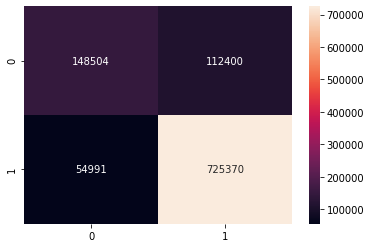

In [161]:
sns.heatmap(confusion_matrix(dataset.Result.values, y_pred_whole), annot=True, fmt='.8g')
plt.show()

In [162]:
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
lst_accu_stratified = [] 

x = dataset.drop(['Result'],axis=1).values
y = dataset.Result.values
   
for train_index, test_index in skf.split(x, y): 
    x_train_fold, x_test_fold = x[train_index], x[test_index] 
    y_train_fold, y_test_fold = y[train_index], y[test_index] 
    model.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(f1_score(y_test_fold, model.predict(x_test_fold)))

In [163]:
# Print the output. 
print('List of possible F1 score:', lst_accu_stratified) 
print('\nMaximum F1 score That can be obtained from this model is:', 
      (np.round(max(lst_accu_stratified)*100, 2)))
print('\nMinimum F1 score:', 
      (np.round(min(lst_accu_stratified)*100,2))) 
print('\nOverall F1 score:', 
     (np.round(np.mean(lst_accu_stratified)*100,2)))
print('\nStandard Deviation is:', np.round(np.std(lst_accu_stratified)))

List of possible F1 score: [0.8334086728587228, 0.8345982808837109, 0.8342140195390113, 0.8338922741121367, 0.8341324087363051]

Maximum F1 score That can be obtained from this model is: 83.46

Minimum F1 score: 83.34

Overall F1 score: 83.4

Standard Deviation is: 0.0


### Saving Model

In [164]:
from joblib import dump, load
dump(model, 'model.joblib') 

['model.joblib']